# Sanity checks on test data

In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

from __future__ import print_function, \
    division, \
    absolute_import

import os

import sep
import h5py

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

from astropy.io import fits
from astropy.modeling import models, fitting

#---------------------------------------------------------------------------#
#User imports
import sys
sys.path.append('/Users/fardila/Documents/Github/kungpao')
from kungpao.galsbp import galSBP
from kungpao.display import display_single, random_cmap

Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
# For Kungpao
x_images = '/Users/fardila/anaconda/envs/hsc_hydro/iraf/bin.macosx/x_images.e'
x_ttools = '/Users/fardila/anaconda/envs/hsc_hydro/iraf_extern/tables/bin.macosx/x_ttools.e'
x_isophote = '/Users/fardila/anaconda/envs/hsc_hydro/iraf_extern/stsdas/bin.macosx/x_isophote.e'
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# About the Colormaps
IMG_CMAP = plt.get_cmap('viridis')
IMG_CMAP.set_bad(color='black')

SEG_CMAP = random_cmap(ncolors=512, background_color=u'white')
SEG_CMAP.set_bad(color='white')
SEG_CMAP.set_under(color='white')

In [3]:
from pyraf import iraf

iraf.tables()
iraf.stsdas()
iraf.analysis()
iraf.isophote()

iraf.unlearn('ellipse')
iraf.unlearn('bmodel')



      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |    
      |                  TABLES Version 3.17                       |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |    
      |                   STSDAS Version 3.17                      |
      |                   

In [4]:
#constants
h=0.704 #Illustris, proper
#HSC: h=0.7, proper distances


In [5]:
def load_pkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle
    
    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)    
        pklFile.close()
    
        return data
    else: 
        warnings.warn("## Can not find %s, return None" % filename)
        return None
    
    
def save_to_fits(image, name):
    """
    Save a 2-D array as fits image.
    """
    hdu = fits.PrimaryHDU(image)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(name, overwrite=True)
    
    return


def show_illustris(img_cen, img_sat, img_icl, img_all, pixel_scale):
    """
    Show the images of Illustris simulated galaxy.
    """
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        top=1.0, right=1.0, 
                        left=0.0, bottom=0.0)

    ax1 = plt.subplot(2, 2, 1)
    ax1 = display_single(img_all, ax=ax1, 
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=pixel_scale,
                         color_bar=True)

    ax2 = plt.subplot(2, 2, 2)
    ax2 = display_single(img_cen, ax=ax2, 
                         contrast=0.10,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=pixel_scale,
                         color_bar=True)

    ax3 = plt.subplot(2, 2, 3)
    ax3 = display_single(img_sat, ax=ax3, 
                         contrast=0.12,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=pixel_scale,
                         color_bar=True)

    ax4 = plt.subplot(2, 2, 4)
    ax4 = display_single(img_icl, ax=ax4, 
                         contrast=0.01,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=pixel_scale,
                         color_bar=True)
    
    return fig

In [6]:
def fit_isophotes(image, iso, iso_bin, prefix, suffix, stage):
    # Here, we use the stsdas.isophote.analysis.bmodel function to reconstruct 
    # a 2-D model using the isophote information 
    # So that we can subtract it from the original image, and see how well it does.
    try: 
        os.remove(prefix + suffix + '_ellip_' + str(stage) + '.fits')
    except Exception: 
        pass

    iraf.bmodel(parent=prefix + suffix + '.fits', 
                table=iso_bin,
                output=prefix + suffix + '_ellip_' + str(stage) + '.fits',
                minsma=0.0,
                highar='no')

    img_ellip = fits.open(prefix + suffix + '_ellip_'+str(stage)+'.fits')[0].data

    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        left=0.0, bottom=0.0,
                        top=1.0, right=1.0)
    ax1 = fig.add_subplot(1, 1, 1)

    ax1 = display_single(image - img_ellip, 
                         ax=ax1,
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='linear',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    # Overplot a subsample of isophotes on the image
    iso_ellip = galSBP.convIso2Ell(iso)
    for ii, e in enumerate(iso_ellip):
        if (ii % 3 == 0):
            ax1.add_artist(e)
            e.set_clip_box(ax1.bbox)
            e.set_alpha(0.6)
            e.set_edgecolor('r')
            e.set_facecolor('none')
            e.set_linewidth(2.0)
    
    return iso_ellip


def check_profile(iso):
    # Normally it is better to also check the profiles for geometry 
    fig = plt.figure(figsize=(8, 7))
    fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        left=0.13, bottom=0.10,
                        top=0.97, right=0.97)

    ax1 = plt.subplot(4, 1, 1)
    ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax1.plot(iso['sma'], iso['x0'], linewidth=3.0)
    ax1.set_ylabel(r'$\mathrm{X}_0$', fontsize=20)

    ax2 = plt.subplot(4, 1, 2)
    ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax2.plot(iso['sma'], iso['y0'], linewidth=3.0)
    ax2.set_ylabel(r'$\mathrm{Y}_0$', fontsize=20)

    ax3 = plt.subplot(4, 1, 3)
    ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax3.plot(iso['sma'], iso['ell'], linewidth=3.0)
    ax3.set_ylabel(r'$e$', fontsize=20)

    ax4 = plt.subplot(4, 1, 4)
    ax4.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax4.plot(iso['sma'], iso['pa'], linewidth=3.0)
    ax4.set_ylabel(r'$\mathrm{PA}$', fontsize=20)
    ax4.set_xlabel(r'$\mathrm{SMA}$', fontsize=25)

# Automate stages 1, 2, 3

In [7]:
def fit_profile(sim_file, pixel_scale, gal_n=0, cen=True, sat=False, icl=False, plots=True):
    
    # Load general simulation and galaxy properties
    f = h5py.File(sim_file, 'r')
    snap_a = f.attrs['snap_a'] #scale factor!
    snap_z = f.attrs['snap_z'] #redshift!
    n_galaxies = len(f['cat_sh_id'])
    sh_idx = np.array(f['cat_sh_id'])
    grp_idx = np.array(f['cat_grp_id'])
    cat_is_primary = np.array(f['cat_grp_is_primary'])
    cat_sh_mstar = np.array(f['cat_sh_mstar'])
    cat_sh_pos_bound = np.array(f['cat_sh_pos_bound'])
    cat_sh_halfmrad_stars = np.array(f['cat_sh_halfmrad_stars'])

    try:
        map_stars = np.array(f['map_stars'])
    except:
        map_stars_insitu = np.array(f['map_stars_insitu'])
        map_stars_exsitu = np.array(f['map_stars_exsitu'])
        map_stars = map_stars_exsitu + map_stars_insitu
    map_size = f.attrs['stellar_map_size']
    n_pixels = f.attrs['stellar_map_np']
    f.close()
    
    #make maps
    img_cen = map_stars[gal_n, 0, 1] * (pixel_scale ** 2) # Central 
    img_sat = map_stars[gal_n, 1, 1] * (pixel_scale ** 2) # Satellites
    img_icl = map_stars[gal_n, 2, 1] * (pixel_scale ** 2) # Diffuse
    img_cen_sat = (img_cen + img_sat)           # Central + Satellites
    img_cen_icl = (img_cen + img_icl)           # Central + Satellites
    img_all = (img_cen + img_sat + img_icl)           # Central + Satellites + Diffuse
    
    #convert the image into unit of stellar mass instead of mass density
    log_mstar = np.log10(cat_sh_mstar[0])
    log_mcen = np.log10(np.sum(img_cen))
    
    #ouput maps
    maps_location='/Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/'
    fits_prefix = maps_location+'illustris_1_xy'
    save_to_fits(img_cen, fits_prefix + '_cen.fits')
    save_to_fits(img_cen_sat, fits_prefix + '_cen_sat.fits')
    save_to_fits(img_cen_icl, fits_prefix + '_cen_icl.fits')
    save_to_fits(img_all, fits_prefix + '_all.fits')
    
    #determine which map to use
    if cen:
        if sat:
            if icl:
                image=img_all
                print('Central+Satellites+ICL')
                suffix='_all'
            else: 
                image=img_cen_sat
                print('Central+Satellites')
                suffix='_cen_sat'
        elif icl:
            image=img_cen_icl
            print('Central+ICL')
            suffix='_cen_icl'
        else:
            image=img_cen
            print('Central only')
            suffix='_cen'
    else:
        raise ValueError('Are you sure you don\'t want to use the central???')
    
    # Measure the background,
    # Here on the image has no noise and has a lot of diffuse features
    # so measure sky using a very small box (bw, bh values) helps us remove 
    # a lot of the them, make the detection easier
    # See: http://sep.readthedocs.io/en/v1.0.x/api/sep.Background.html#sep.Background 
    # For more details
    bkg = sep.Background(image, bw=10, bh=10, fw=5, fh=5)
    print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg.globalback, bkg.globalrms))

    
    # Object detection after subtracting the background
    # Since there is no noise on the image, we will just use the global RMS 
    # from the background estimate as error
    # Here, we use very high threshold, less aggressive deblending method to 
    # make the detection focuses on the big object
    objs, seg = sep.extract(image - bkg.back(), 
                                    20.0,
                                    err=bkg.globalrms,
                                    minarea=1000,
                                    deblend_nthresh=24, 
                                    deblend_cont=0.1,
                                    segmentation_map=True)
    
    # And this is how you turn the segmentation image into a mask
    # You can remove certain object from the segmentation map first
    seg_mask = (seg > 0)
    print("# Detect %d objects" % len(objs))

    #################################################################################################
    #stage 1: Free center and geometry
    #################################################################################################
    print('****************STAGE 1****************')
    stage = 1
    iso_1, iso_1_bin = galSBP.galSBP(maps_location+'illustris_1_xy'+suffix+'.fits', 
                                             galX=objs[0]['x'], 
                                             galY=objs[0]['y'], 
                                             galQ=(objs[0]['b'] / objs[0]['a']), 
                                             galPA=(objs[0]['theta'] * 180.0 / np.pi), 
                                             maxSma=150, 
                                             iniSma=10.0, 
                                             stage=1, 
                                             intMode='median', 
                                             ellipStep=0.1,
                                             pix=pixel_scale, 
                                             zpPhoto=0.0,
                                             isophote=x_isophote, 
                                             xttools=x_ttools,
                                             savePng=False, verbose=True)
    print('# Output file : %s' % iso_1_bin)
    print('# Total stellar mass from the profile: logM = %7.4f' % (iso_1['mag_tot'][0] / -2.5))
    
    if plots:
        iso_ellip = fit_isophotes(image, iso_1, iso_1_bin, fits_prefix, suffix, stage)
        check_profile(iso_1)
    
    
    #################################################################################################
    #stage 2: fixed center, and let the geometry to be free
    #################################################################################################
    print('****************STAGE 2****************')
    stage=2
    
    iso_2, iso_2_bin = galSBP.galSBP(maps_location+'illustris_1_xy'+suffix+'.fits', 
                                             galX=100.0, 
                                             galY=100.0, 
                                             galQ=0.6, 
                                             galPA=-50.0, 
                                             maxSma=220, 
                                             iniSma=10.0, 
                                             stage=2, 
                                             intMode='median', 
                                             ellipStep=0.05,
                                             pix=pixel_scale, 
                                             zpPhoto=0.0,
                                             harmonics='1 2 3 4',
                                             isophote=x_isophote, 
                                             xttools=x_ttools,
                                             recenter=False,
                                             savePng=False, 
                                             verbose=True)
    print('# Output file : %s' % iso_2_bin)
    print('# Total stellar mass from the profile: logM = %7.4f' % (iso_2['mag_tot'][0] / -2.5))

    if plots:
        iso_ellip = fit_isophotes(image, iso_2, iso_2_bin, fits_prefix, suffix, stage)
        check_profile(iso_2)
    
    
    ###########################################################################
    #stage 3: fix everything
    ###########################################################################        
    print('****************STAGE 3****************')
    stage=3
    
    iso_3, iso_3_bin = galSBP.galSBP(maps_location+'illustris_1_xy'+suffix+'.fits', 
                                             galX=100.0, 
                                             galY=100.0, 
                                             galQ=iso_2['avg_q'][0], 
                                             galPA=iso_2['avg_pa'][0], 
                                             maxSma=250, 
                                             iniSma=50.0, 
                                             stage=3, 
                                             intMode='median', 
                                             ellipStep=0.05,
                                             pix=pixel_scale, 
                                             zpPhoto=0.0,
                                             harmonics='1 2 3 4',
                                             isophote=x_isophote, 
                                             xttools=x_ttools,
                                             recenter=True,
                                             savePng=False, 
                                             verbose=True)
    print('# Output file : %s' % iso_3_bin)
    print('# Total stellar mass from the profile: logM = %7.4f' % (iso_3['mag_tot'][0] / -2.5))
    
    if plots:
        iso_ellip = fit_isophotes(image, iso_3, iso_3_bin, fits_prefix, suffix, stage)
        check_profile(iso_3)
            
    ########################################################################### 
    
    return iso_3, iso_3_bin

## make profiles

In [8]:
def oneD_profile(iso):
    
    #fit Sersic profiles
    fitter = fitting.LevMarLSQFitter()
    r_mask = (iso['sma'] * 3.0 > 6.0)
    xx = iso['sma'][r_mask]
    yy = iso['intens'][r_mask] / 9.0

    # Let try to fit a Sersic function
    ser1_init = models.Sersic1D(amplitude=np.nanmedian(iso['intens'] / 9.0), 
                                r_eff=6.5, n=6.0)
    ser1_fit = fitter(ser1_init, xx, yy)
    print("# 1-Sersic model:")
    print(ser1_fit.r_eff * 3.0, ser1_fit.n)

    # Let try to fit 2-Sersic functions then
    ser2_init = models.Sersic1D(amplitude=np.nanmedian(iso['intens'] / 8.0), 
                                r_eff=2.5, n=3.0) + \
                models.Sersic1D(amplitude=np.nanmedian(iso['intens'] / 12.0), 
                                r_eff=20.5, n=2.0)
    ser2_fit = fitter(ser2_init, xx, yy)
    print("\n# 2-Sersic model:")
    print(ser2_fit.r_eff_0 * 3.0, ser2_fit.n_0)
    print(ser2_fit.r_eff_1 * 3.0, ser2_fit.n_1)

    # Let try to fit 3-Sersic functions then
    ser3_init = models.Sersic1D(amplitude=np.nanmedian(iso['intens'] / 6.0), 
                                r_eff=2.5, n=2.0) + \
                models.Sersic1D(amplitude=np.nanmedian(iso['intens'] / 10.0), 
                                r_eff=12.5, n=1.5) + \
                models.Sersic1D(amplitude=np.nanmedian(iso['intens'] / 15.0), 
                                r_eff=25.5, n=1.0)
    ser3_fit = fitter(ser3_init, xx, yy)
    print("\n# 3-Sersic model:")
    print(ser3_fit.r_eff_0 * 3.0, ser3_fit.n_0)
    print(ser3_fit.r_eff_1 * 3.0, ser3_fit.n_1)
    print(ser3_fit.r_eff_2 * 3.0, ser3_fit.n_2)
    
    
    #Plot the 1-D mass density profile, the curve-of-growth of mass, and the residuals

    # I label the 6.0 kpc (twice the pixel size, not resolved within) and 100 kpc radius
    fig = plt.figure(figsize=(8, 7))
    fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        left=0.13, bottom=0.10,
                        top=0.97, right=0.97)

    ax1 = plt.subplot(3, 1, 1)
    ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax1.plot((iso['sma'] * 3.0) ** 0.25, 
             np.log10(iso['intens'] / 9.0), linewidth=3.0,
             label=r'$\mathrm{Central}$')
    ax1.plot((iso['sma'] * 3.0) ** 0.25, 
             np.log10(ser1_fit(iso['sma'])), linewidth=3.0, alpha=0.5,
             linestyle='--', label=r'$\mathrm{1\ Sersic}$')
    ax1.plot((iso['sma'] * 3.0) ** 0.25, 
             np.log10(ser2_fit(iso['sma'])), linewidth=3.0, alpha=0.5,
             linestyle='--', label=r'$\mathrm{2\ Sersic}$')
    ax1.plot((iso['sma'] * 3.0) ** 0.25, 
             np.log10(ser3_fit(iso['sma'])), linewidth=3.0, alpha=0.5,
             linestyle='--', label=r'$\mathrm{3\ Sersic}$')
    ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
    ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
    ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
    ax1.set_xlim(1.0, 4.5)
    ax1.set_ylim(4.0, 11.0)
    ax1.legend(fontsize=14)
    
    ax2 = plt.subplot(3, 1, 2)
    ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax2.plot([0.0, 4.5], [0.0, 0.0])
    ax2.plot((iso['sma'] * 3.0) ** 0.25, 
             (np.log10(iso['intens'] / 9.0) - 
              np.log10(ser1_fit(iso['sma']))), 
             linewidth=3.0, alpha=0.5,
             linestyle='--', label=r'$\mathrm{1\ Sersic}$')
    ax2.plot((iso['sma'] * 3.0) ** 0.25, 
             (np.log10(iso['intens'] / 9.0) - 
              np.log10(ser2_fit(iso['sma']))), 
             linewidth=3.0, alpha=0.5,
             linestyle='--', label=r'$\mathrm{2\ Sersic}$')
    ax2.plot((iso['sma'] * 3.0) ** 0.25, 
             (np.log10(iso['intens'] / 9.0) - 
              np.log10(ser3_fit(iso['sma']))), 
             linewidth=3.0, alpha=0.5,
             linestyle='--', label=r'$\mathrm{3\ Sersic}$')
    ax2.set_ylabel(r'$\mathrm{Residuals}$', fontsize=20)
    ax2.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
    ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
    ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
    ax2.set_xlim(1.0, 4.5)
    #ax2.set_ylim(-2.0, 2.0)
    

    ax3 = plt.subplot(3, 1, 3)
    ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax3.plot((iso['sma'] * 3.0) ** 0.25, 
             np.log10(iso['growth_ori']), linewidth=3.0)
    ax3.set_ylabel(r'$\mathrm{Curve\ of\ growth}\ (M_{\star})$', fontsize=20)
    ax3.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
    ax3.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
    ax3.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
    ax3.set_xlim(1.0, 4.5)
    

# Illustris stellar mass maps

In [9]:
illustris_file_orig = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/galaxies_orig.hdf5'
illustris_file_large = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/galaxies_orig_large.hdf5'
illustris_file_highres = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/galaxies_orig_highres.hdf5'
illustris_file_full = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/galaxies_orig_11.2.hdf5'

In [9]:
for illustris_file in [illustris_file_large, illustris_file_highres, illustris_file_full]:
    
    #explore new data
    f = h5py.File(illustris_file, 'r')
    print(f.keys())
    print(f.attrs.keys())
    snap_a = f.attrs['snap_a'] #scale factor!
    snap_z = f.attrs['snap_z'] #redshift!
    n_galaxies = len(f['cat_sh_id'])
    sh_idx = np.array(f['cat_sh_id'])
    grp_idx = np.array(f['cat_grp_id'])
    cat_is_primary = np.array(f['cat_grp_is_primary'])
    cat_sh_mstar = np.array(f['cat_sh_mstar'])
    cat_sh_pos_bound = np.array(f['cat_sh_pos_bound'])
    cat_sh_halfmrad_stars = np.array(f['cat_sh_halfmrad_stars'])

    map_size = f.attrs['stellar_map_size']
    n_pixels = f.attrs['stellar_map_np']
    f.close()

    pixel_scale = 2 * (map_size/n_pixels)

    print(snap_a)
    print(pixel_scale)
    print(n_galaxies, ' galaxies')

[u'cat_grp_id', u'cat_grp_is_primary', u'cat_grp_m200c', u'cat_grp_n', u'cat_sh_bh_mdot', u'cat_sh_halfmrad_gas', u'cat_sh_halfmrad_stars', u'cat_sh_id', u'cat_sh_mbh', u'cat_sh_mdm', u'cat_sh_mdm_2rhalf', u'cat_sh_mdm_rhalf', u'cat_sh_metallicity', u'cat_sh_mgas', u'cat_sh_mgas_2rhalf', u'cat_sh_mgas_rhalf', u'cat_sh_mstar', u'cat_sh_mstar_2rhalf', u'cat_sh_mstar_rhalf', u'cat_sh_phot_B', u'cat_sh_phot_K', u'cat_sh_phot_U', u'cat_sh_phot_V', u'cat_sh_phot_g', u'cat_sh_phot_i', u'cat_sh_phot_r', u'cat_sh_phot_z', u'cat_sh_pos_bound', u'cat_sh_pos_cm', u'cat_sh_sfr', u'cat_sh_spin', u'cat_sh_vel', u'cat_sh_vmax', u'map_stars_exsitu', u'map_stars_exsitu_nptl', u'map_stars_insitu', u'map_stars_insitu_nptl']
[u'sim', u'snap_idx', u'snap_a', u'snap_z', u'stellar_map_size', u'stellar_map_np']
0.71432
15.0
5  galaxies
[u'cat_grp_id', u'cat_grp_is_primary', u'cat_grp_m200c', u'cat_grp_n', u'cat_sh_bh_mdot', u'cat_sh_halfmrad_gas', u'cat_sh_halfmrad_stars', u'cat_sh_id', u'cat_sh_mbh', u'cat_sh

# test large vs. highres

# original


## show maps

GALAXY 0
12.4148511258 12.3464206026


/Users/fardila/Documents/Github/kungpao/kungpao/display.py:153: RuntimeWarning: divide by zero encountered in log10
  img_scale = np.log10(img)


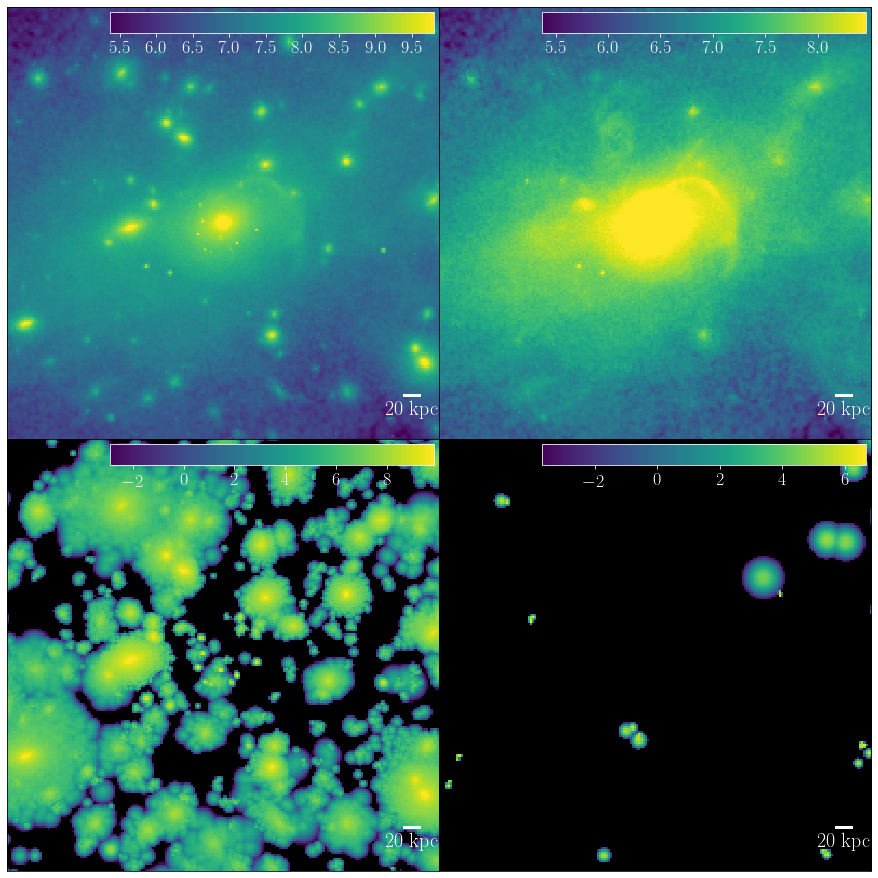

GALAXY 1
12.4148511258 12.2861580053


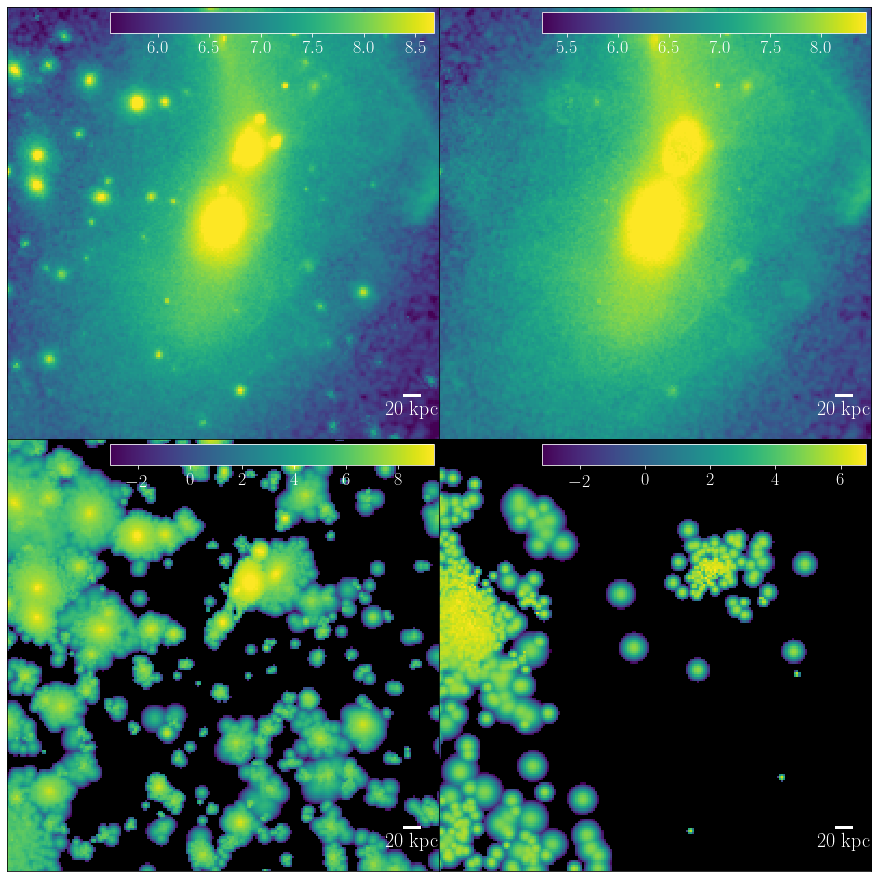

GALAXY 2
12.4148511258 12.2642524159


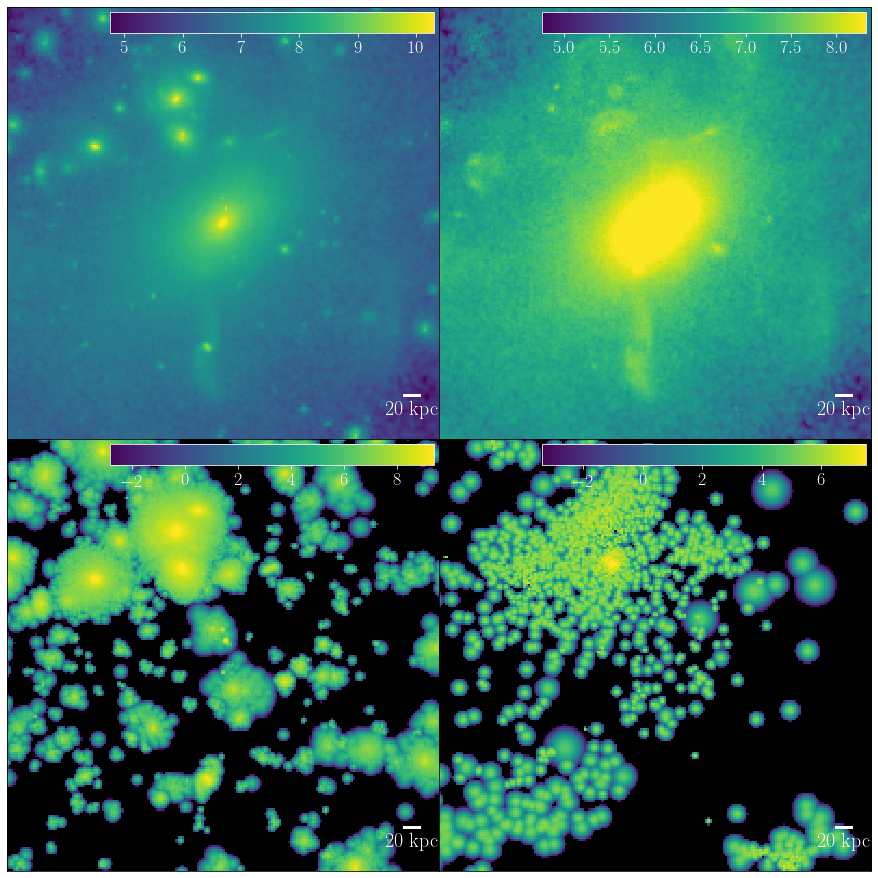

GALAXY 3
12.4148511258 12.236023465


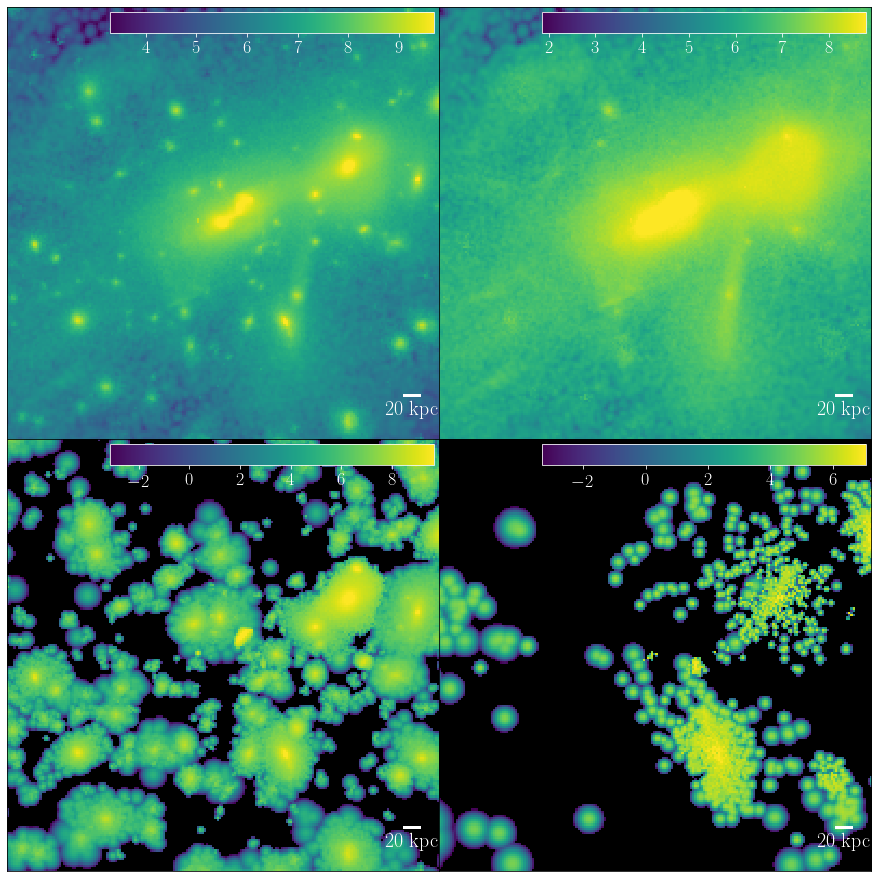

GALAXY 4
12.4148511258 12.2126857223


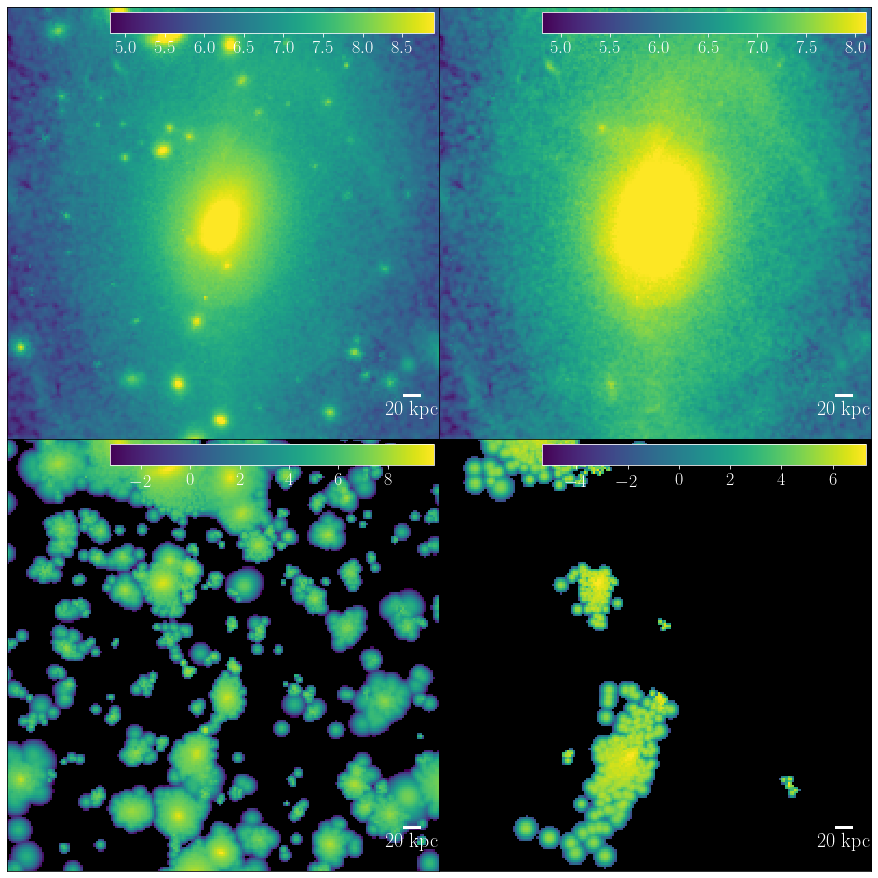

In [11]:
f = h5py.File(illustris_file_orig, 'r')
cat_sh_mstar = np.array(f['cat_sh_mstar'])
# map_stars_insitu = np.array(f['map_stars_insitu'])
# map_stars_exsitu = np.array(f['map_stars_exsitu'])
# map_stars = map_stars_insitu + map_stars_exsitu
map_stars = np.array(f['map_stars'])
map_size = f.attrs['stellar_map_size']
n_pixels = f.attrs['stellar_map_np']
f.close()

pixel_scale = 2 * (map_size/n_pixels)




summed_masses=[]

for i in range(5):
    print('GALAXY '+str(i))
    img_cen = map_stars[i, 0, 1] * (pixel_scale ** 2) # Central 
    img_sat = map_stars[i, 1, 1] * (pixel_scale ** 2) # Satellites
    img_icl = map_stars[i, 2, 1] * (pixel_scale ** 2) # Diffuse
    img_cen_icl = (img_cen + img_icl)           # Central + Diffuse
    img_all = (img_cen + img_sat + img_icl)           # Central + Satellites + Diffuse
    # We convert the image into unit of stellar mass instead of mass density

    log_mstar = np.log10(cat_sh_mstar[0])
    log_mcen = np.log10(np.sum(img_cen))
    print(log_mstar, log_mcen)
    summed_masses.append(log_mcen)

    #fits_prefix = 'illustris_1_xy'

    # save_to_fits(img_cen, fits_prefix + '_cen.fits')
    # save_to_fits(img_cen_icl, fits_prefix + '_cen_icl.fits')
    # save_to_fits(img_all, fits_prefix + '_all.fits')

    _ = show_illustris(img_cen, img_sat, img_icl, img_all, pixel_scale)
    plt.show()
    


### compare maps

In [12]:
isos=[]

for i in range(5):
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    print('^^^^^^^^GALAXY '+str(i)+'^^^^^^^^^^^^^^')
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')

    iso_cen, iso_cen_bin = fit_profile(illustris_file_orig,pixel_scale=pixel_scale,gal_n=i, plots=False)
    m_star=np.log10(cat_sh_mstar[i])
    
    isos.append([iso_cen,m_star])
    

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 0^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Central only
# Mean Sky / RMS Sky = 11164598.00000 / 2206234.00000
# Detect 1 objects
****************STAGE 1****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  99.3166203806 99.7277590835
###      galR :  20.0
###      iniSma, maxSma :  10.0 150
###      Stage :  1
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/

/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1614: RuntimeWarning: invalid value encountered in log10
  expTime))



# Total stellar mass from the profile: logM = 12.2320
****************STAGE 2****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  10.0 220
###      Stage :  2
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen.fits
###      Input Image   : temp_9TH7Q.fits
###      Output B

/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1614: RuntimeWarning: divide by zero encountered in log10
  expTime))



###     Input background value   :  0.0
###     1-D SBP background value :  25460100.0
###     Current outer background :  25460100.0
----------------------------------------------------------------------------------------------------
# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_1.bin
# Total stellar mass from the profile: logM = 12.0826
****************STAGE 2****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  10.0 220
###      Stage :  2
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  7692239.5
###     Current outer background :  7692239.5
----------------------------------------------------------------------------------------------------
# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_3.bin
# Total stellar mass from the profile: logM = 12.1626
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 3^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Central only
# Mean Sky / RMS Sky = 2672209.50000 / 900019.93750
# Detect 1 objects
****************STAGE 1****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  111.483699957 106.141581868
###      galR :  20.0
#

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  7669354.5
###     Current outer background :  7669354.5
----------------------------------------------------------------------------------------------------
# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_2.bin
# Total stellar mass from the profile: logM = 12.1254
****************STAGE 3****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up

In [26]:
for i in range(5):
    print('----------')
    print('Galaxy '+ str(i))
    print('----------')
    iso=isos[i]
    summed_mass= summed_masses[i]
    print('Catalog Mass: '+ str(iso[1]))
    print('Summed Mass from pixels: ' + str(summed_mass))
    print('Integrated Mass from fit: ' + str(iso[0]['mag_tot'][0]/-2.5))

----------
Galaxy 0
----------
Catalog Mass: 12.4148511258
Summed Mass from pixels: 12.3464206026
Integrated Mass from fit: 12.1951889686
----------
Galaxy 1
----------
Catalog Mass: 12.335451206
Summed Mass from pixels: 12.2861580053
Integrated Mass from fit: 12.1068107126
----------
Galaxy 2
----------
Catalog Mass: 12.3069925484
Summed Mass from pixels: 12.2642524159
Integrated Mass from fit: 12.1626131413
----------
Galaxy 3
----------
Catalog Mass: 12.258741665
Summed Mass from pixels: 12.236023465
Integrated Mass from fit: 11.9993044946
----------
Galaxy 4
----------
Catalog Mass: 12.2364731503
Summed Mass from pixels: 12.2126857223
Integrated Mass from fit: 12.127727212


## Large

### Show maps

GALAXY 0
12.4148511258 12.3716613911


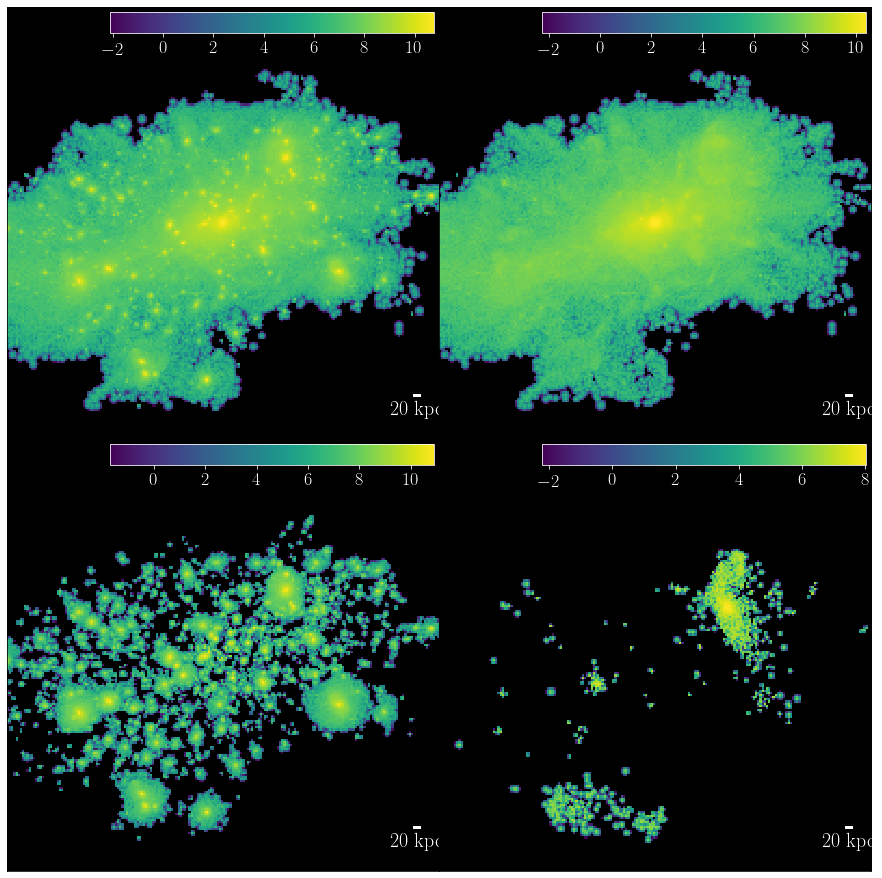

GALAXY 1
12.4148511258 12.2768213862


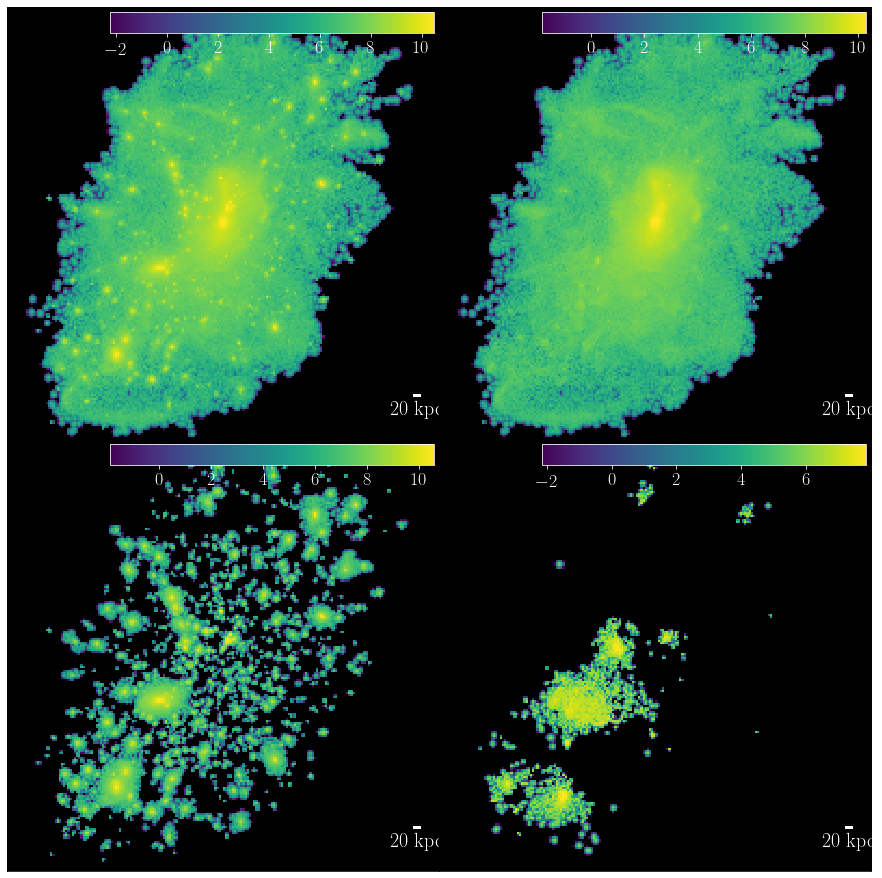

GALAXY 2
12.4148511258 12.2412141142


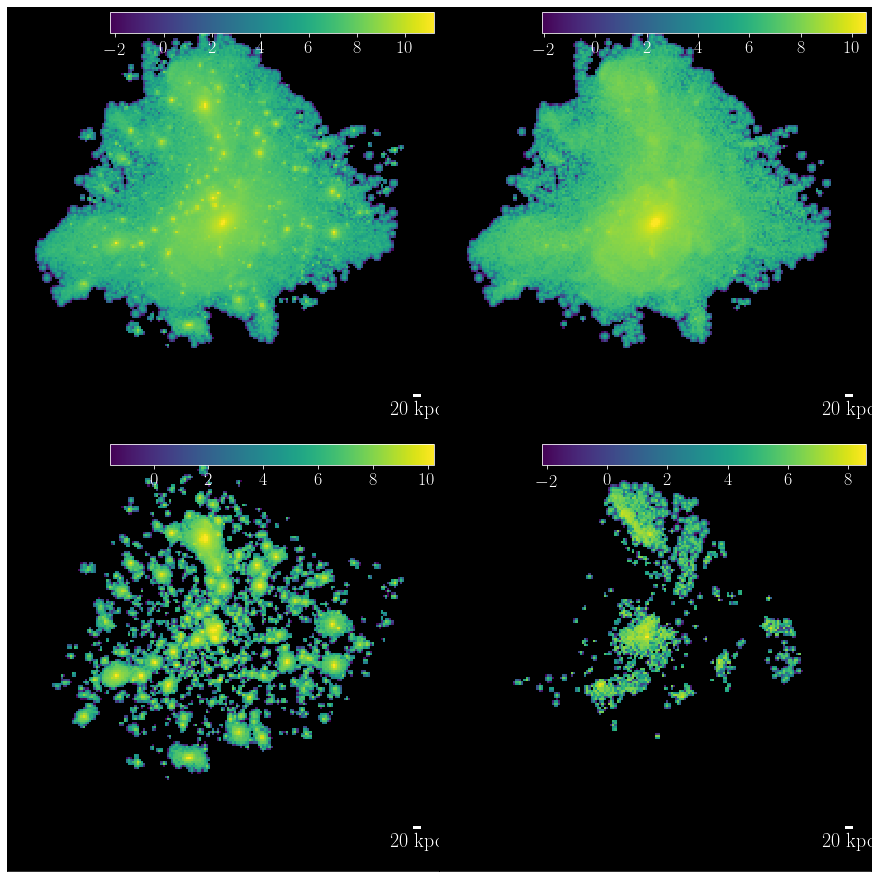

GALAXY 3
12.4148511258 12.2129906571


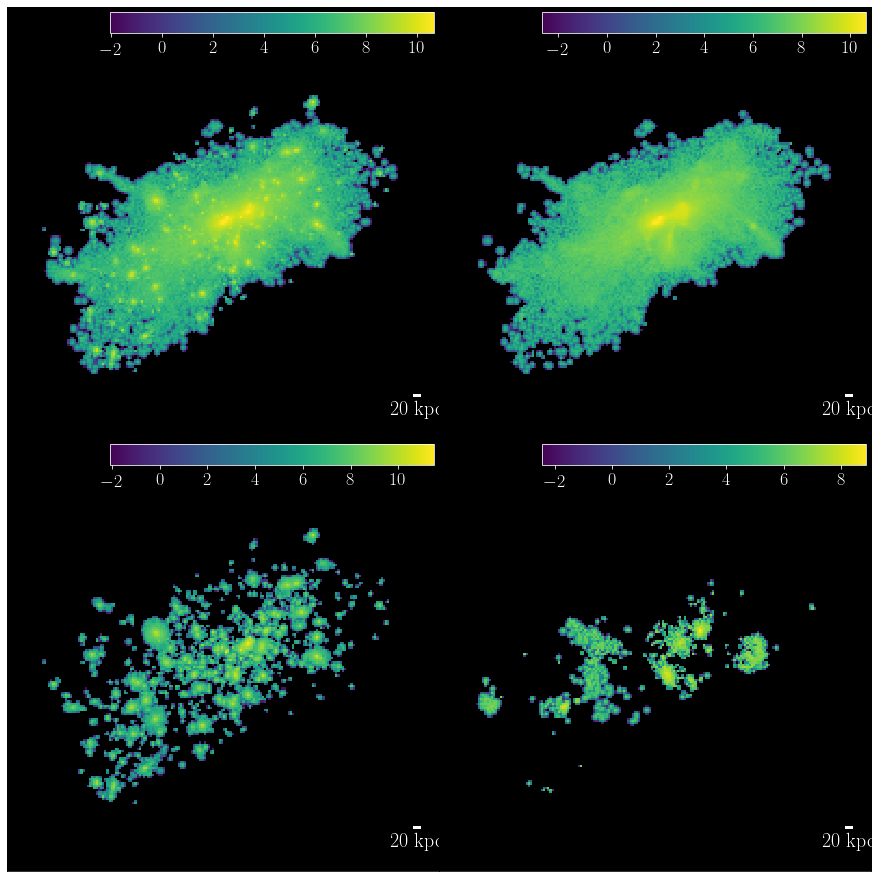

GALAXY 4
12.4148511258 12.211279999


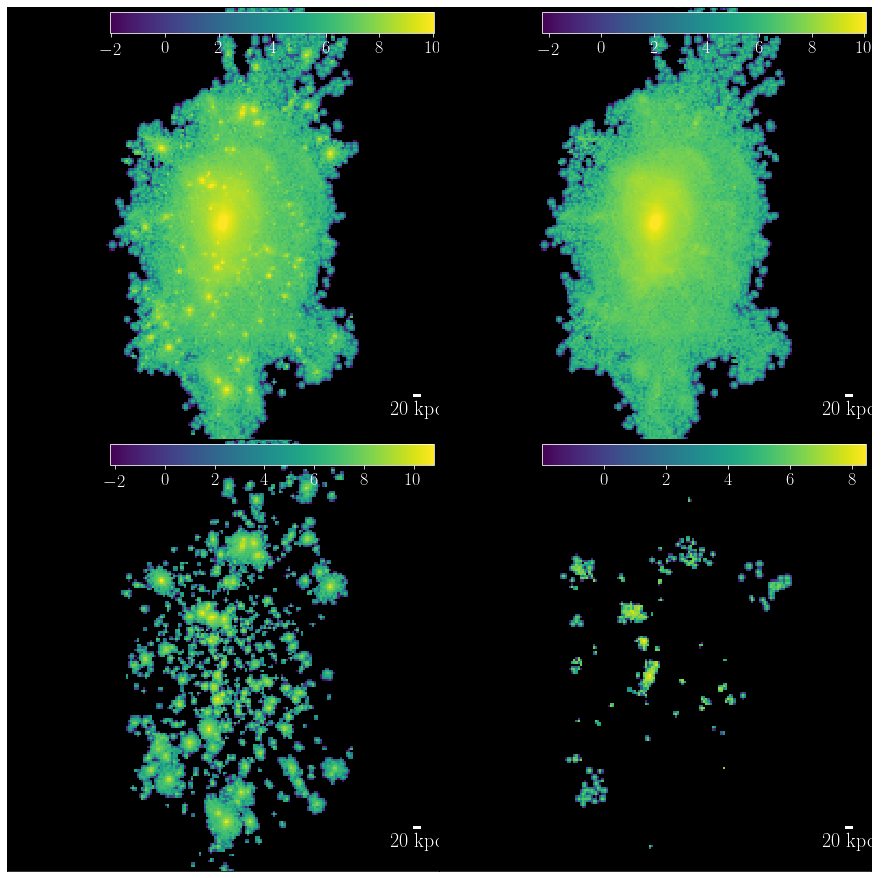

In [28]:
f = h5py.File(illustris_file_large, 'r')
cat_sh_mstar = np.array(f['cat_sh_mstar'])
map_stars_insitu = np.array(f['map_stars_insitu'])
map_stars_exsitu = np.array(f['map_stars_exsitu'])
map_stars = map_stars_insitu + map_stars_exsitu

map_size = f.attrs['stellar_map_size']
n_pixels = f.attrs['stellar_map_np']
f.close()

pixel_scale = 2 * (map_size/n_pixels)




summed_masses=[]

for i in range(5):
    print('GALAXY '+str(i))
    img_cen = map_stars[i, 0, 1] * (pixel_scale ** 2) # Central 
    img_sat = map_stars[i, 1, 1] * (pixel_scale ** 2) # Satellites
    img_icl = map_stars[i, 2, 1] * (pixel_scale ** 2) # Diffuse
    img_cen_icl = (img_cen + img_icl)           # Central + Diffuse
    img_all = (img_cen + img_sat + img_icl)           # Central + Satellites + Diffuse
    # We convert the image into unit of stellar mass instead of mass density

    log_mstar = np.log10(cat_sh_mstar[0])
    log_mcen = np.log10(np.sum(img_cen))
    print(log_mstar, log_mcen)
    summed_masses.append(log_mcen)

    #fits_prefix = 'illustris_1_xy'

    # save_to_fits(img_cen, fits_prefix + '_cen.fits')
    # save_to_fits(img_cen_icl, fits_prefix + '_cen_icl.fits')
    # save_to_fits(img_all, fits_prefix + '_all.fits')

    _ = show_illustris(img_cen, img_sat, img_icl, img_all, pixel_scale)
    plt.show()
    


### compare masses

In [29]:
isos=[]

for i in range(5):
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    print('^^^^^^^^GALAXY '+str(i)+'^^^^^^^^^^^^^^')
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')

    iso_cen, iso_cen_bin = fit_profile(illustris_file_large,pixel_scale=pixel_scale,gal_n=i, plots=False)
    m_star=np.log10(cat_sh_mstar[i])
    
    isos.append([iso_cen,m_star])
    

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 0^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Central only
# Mean Sky / RMS Sky =  414.88403 / 4558.17676
# Detect 1 objects
****************STAGE 1****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  99.2083564374 99.8298868949
###      galR :  20.0
###      iniSma, maxSma :  10.0 150
###      Stage :  1
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documen

# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_2.bin
# Total stellar mass from the profile: logM = 12.2091
****************STAGE 3****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  0.0
###     Current outer background :  0.0
----------------------------------------------------------------------------------------------------
# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_2.bin
# Total stellar mass from the profile: logM = 12.1515
****************STAGE 3****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse

In [30]:
for i in range(5):
    print('----------')
    print('Galaxy '+ str(i))
    print('----------')
    iso=isos[i]
    summed_mass= summed_masses[i]
    print('Catalog Mass: '+ str(iso[1]))
    print('Summed Mass from pixels: ' + str(summed_mass))
    print('Integrated Mass from fit: ' + str(iso[0]['mag_tot'][0]/-2.5))

----------
Galaxy 0
----------
Catalog Mass: 12.4148511258
Summed Mass from pixels: 12.3716613911
Integrated Mass from fit: 12.308825239
----------
Galaxy 1
----------
Catalog Mass: 12.335451206
Summed Mass from pixels: 12.2768213862
Integrated Mass from fit: 12.2154237391
----------
Galaxy 2
----------
Catalog Mass: 12.3069925484
Summed Mass from pixels: 12.2412141142
Integrated Mass from fit: 12.2033939322
----------
Galaxy 3
----------
Catalog Mass: 12.258741665
Summed Mass from pixels: 12.2129906571
Integrated Mass from fit: 12.1620434977
----------
Galaxy 4
----------
Catalog Mass: 12.2364731503
Summed Mass from pixels: 12.211279999
Integrated Mass from fit: 12.1665153126


## Highres

### maps

GALAXY 0
12.4148511258 12.3821635812


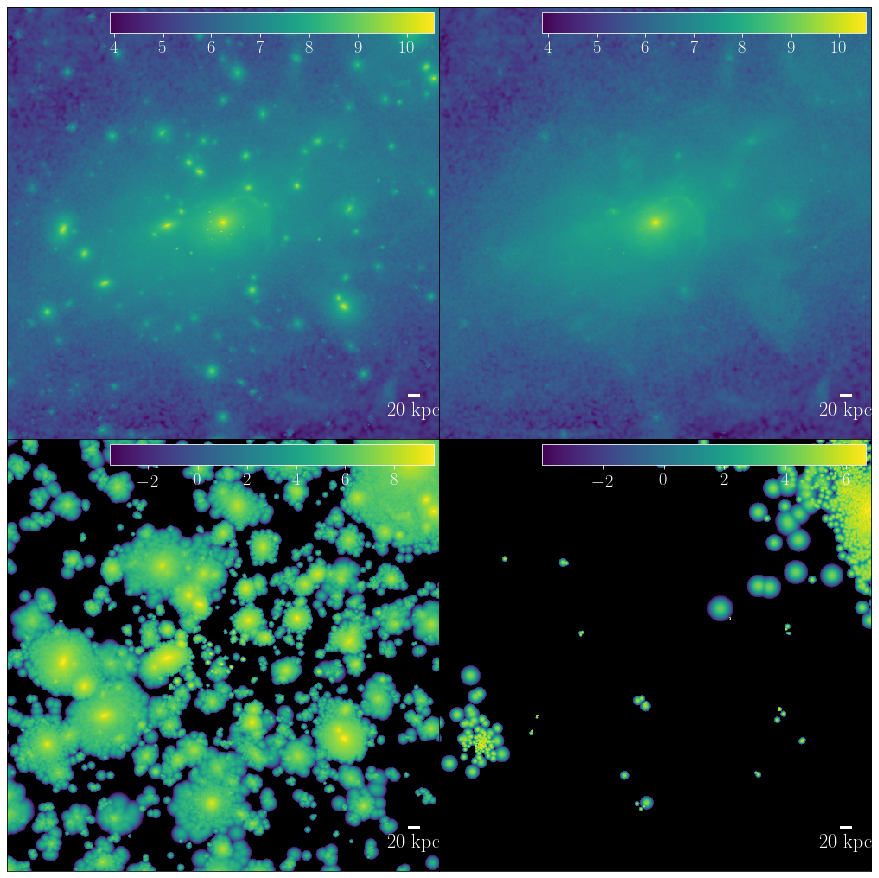

GALAXY 1
12.4148511258 12.315595784


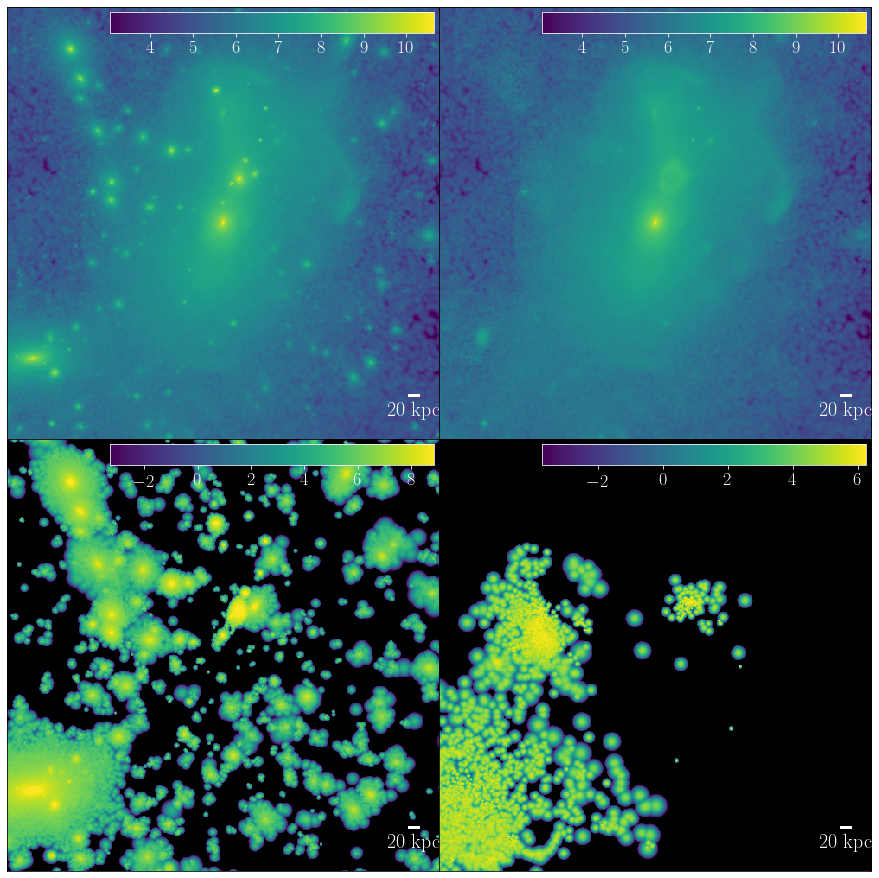

GALAXY 2
12.4148511258 12.2881008186


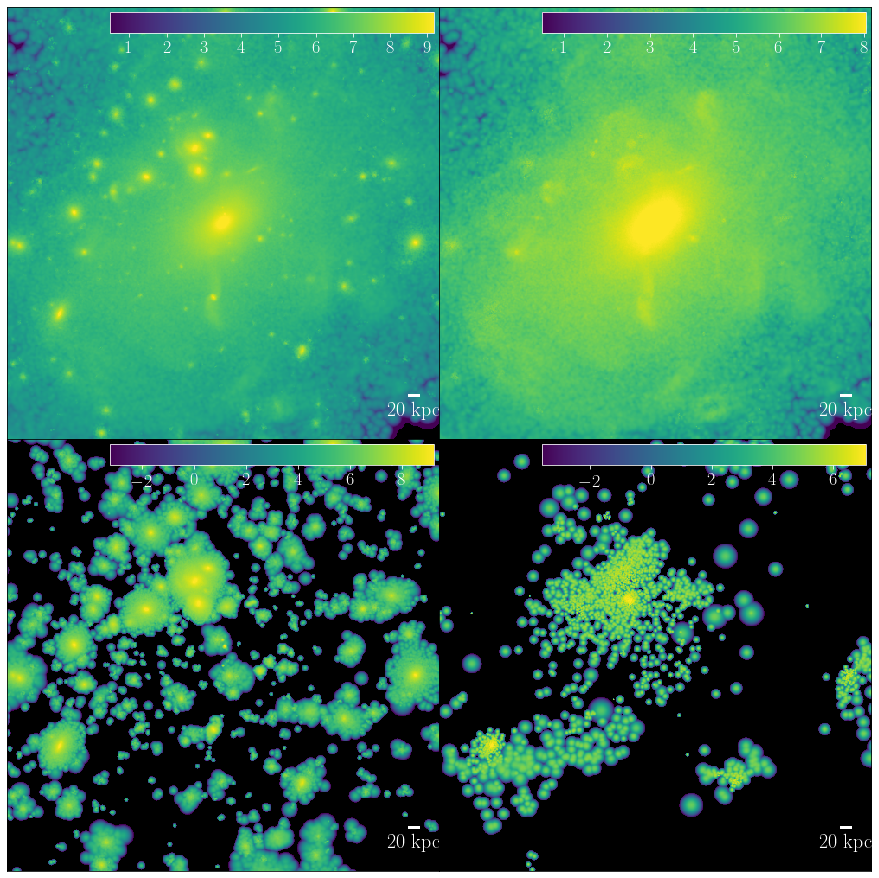

GALAXY 3
12.4148511258 12.2524194304


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


GALAXY 4
12.4148511258 12.2296540349


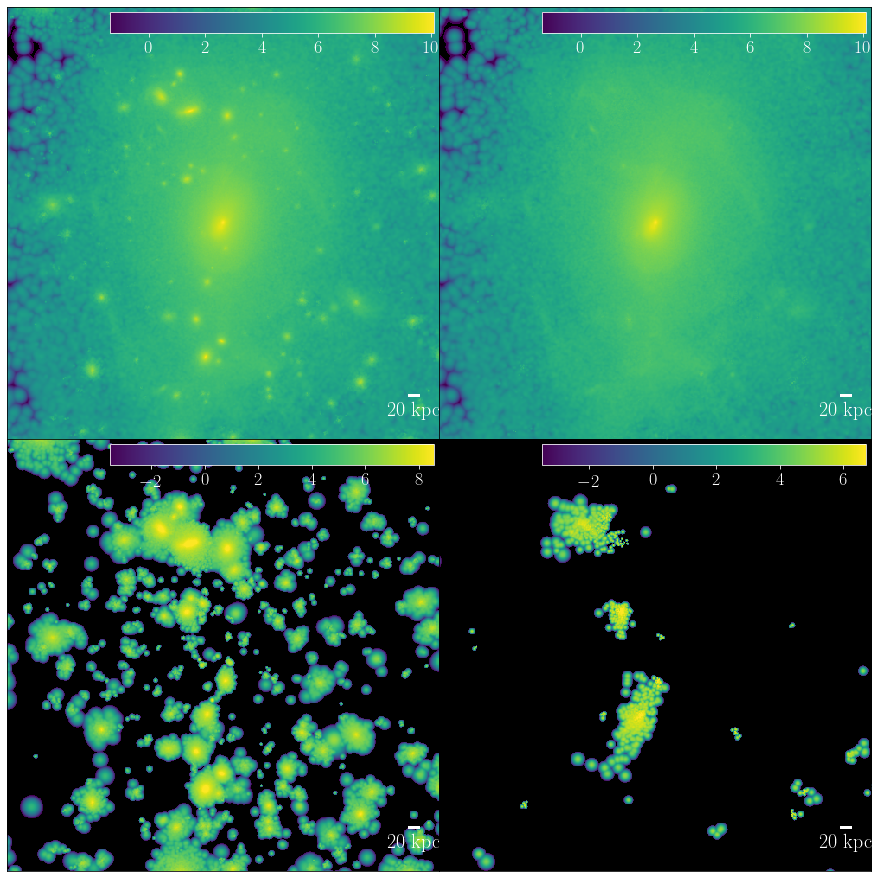

In [31]:
f = h5py.File(illustris_file_highres, 'r')
map_stars_insitu = np.array(f['map_stars_insitu'])
map_stars_exsitu = np.array(f['map_stars_exsitu'])
map_size = f.attrs['stellar_map_size']
n_pixels = f.attrs['stellar_map_np']
f.close()

pixel_scale = 2 * (map_size/n_pixels)
map_stars = map_stars_insitu + map_stars_exsitu



summed_masses=[]

for i in range(5):
    print('GALAXY '+str(i))
    img_cen = map_stars[i, 0, 1] * (pixel_scale ** 2) # Central 
    img_sat = map_stars[i, 1, 1] * (pixel_scale ** 2) # Satellites
    img_icl = map_stars[i, 2, 1] * (pixel_scale ** 2) # Diffuse
    img_cen_icl = (img_cen + img_icl)           # Central + Diffuse
    img_all = (img_cen + img_sat + img_icl)           # Central + Satellites + Diffuse
    # We convert the image into unit of stellar mass instead of mass density

    log_mstar = np.log10(cat_sh_mstar[0])
    log_mcen = np.log10(np.sum(img_cen))
    print(log_mstar, log_mcen)
    summed_masses.append(log_mcen)

    fits_prefix = 'illustris_1_xy'

    # save_to_fits(img_cen, fits_prefix + '_cen.fits')
    # save_to_fits(img_cen_icl, fits_prefix + '_cen_icl.fits')
    # save_to_fits(img_all, fits_prefix + '_all.fits')

    _ = show_illustris(img_cen, img_sat, img_icl, img_all, pixel_scale)
    plt.show()
    


### compare masses

In [32]:
isos=[]

for i in range(5):
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    print('^^^^^^^^GALAXY '+str(i)+'^^^^^^^^^^^^^^')
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')

    iso_cen, iso_cen_bin = fit_profile(illustris_file_highres,pixel_scale=pixel_scale,gal_n=i, plots=False)
    m_star=np.log10(cat_sh_mstar[i])
    
    isos.append([iso_cen,m_star])
    

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 0^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Central only
# Mean Sky / RMS Sky = 1212615.25000 / 275485.75000
# Detect 1 objects
****************STAGE 1****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  248.983649864 249.592849627
###      galR :  20.0
###      iniSma, maxSma :  10.0 150
###      Stage :  1
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Do

----------------------------------------------------------------------------------------------------
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
###  ELLIPSE RUN FAILED IN ATTEMPT:  1
###  Error Information :  XXX Can not find the outBin: /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_2.bin!
###  !!! Make the Ellipse Run A Little Bit Easier !
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
----------------------------------------------------------------------------------------------------
###  Maxsma  198.0 -->  178.2
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  3
----------------------------------------------------------------------

TypeError: 'NoneType' object has no attribute '__getitem__'

In [ ]:
for i in range(5):
    print('----------')
    print('Galaxy '+ str(i))
    print('----------')
    iso=isos[i]
    summed_mass= summed_masses[i]
    print('Catalog Mass: '+ str(iso[1]))
    print('Summed Mass from pixels: ' + str(summed_mass))
    print('Integrated Mass from fit: ' + str(iso[0]['mag_tot'][0]/-2.5))

# Compare to HSC

In [13]:
hsc_data='/Users/fardila/Documents/Github/HSC_vs_hydro/Data/HSC/'
hscAvgProf0 = load_pkl(hsc_data+"hscAvgProf0.pkl")
hscAvgProf1 = load_pkl(hsc_data+"hscAvgProf1.pkl")
hscAvgProf2 = load_pkl(hsc_data+"hscAvgProf2.pkl")

rm0_sl, rm0_ml, rm0_aml = hscAvgProf0['all'], hscAvgProf0['med'], hscAvgProf0['avg']
rm1_sl, rm1_ml, rm1_aml = hscAvgProf1['all'], hscAvgProf1['med'], hscAvgProf1['avg']
rm2_sl, rm2_ml, rm2_aml = hscAvgProf2['all'], hscAvgProf2['med'], hscAvgProf2['avg']

# Universal RSMA array
RSMA_COMMON = np.arange(0.4, 4.2, 0.01)

# These are the median stellar mass density profiles for HSC galaxies at 0.3 < z < 0.5
# in three mass bins
# rm0 : 11.4 < logM_100kpc < 11.6 
# rm1 : 11.6 < logM_100kpc < 11.8 
# rm2 : 11.8 < logM_100kpc < 12.0 
# They are on a common radius array, and we use (r ** 0.25) as radius

In [17]:
isos=[]

for i in range(5):
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    print('^^^^^^^^GALAXY '+str(i)+'^^^^^^^^^^^^^^')
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')

    iso_cen, iso_cen_bin = fit_profile(illustris_file,pixel_scale=pixel_scale,gal_n=i, plots=False)
    m_star=np.log10(cat_sh_mstar[i])
    
    isos.append([iso_cen,m_star])
    

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 0^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Central only
# Mean Sky / RMS Sky = 2791149.50000 / 551558.50000
# Detect 1 objects
****************STAGE 1****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  99.3166203806 99.7277590835
###      galR :  20.0
###      iniSma, maxSma :  10.0 150
###      Stage :  1
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Do

----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  4031806.0
###     Current outer background :  4031806.0
----------------------------------------------------------------------------------------------------
# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_2.bin
# Total stellar mass from the profile: logM = 11.5038
****************STAGE 3****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
--------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  676538.05
###     Current outer background :  676538.05
----------------------------------------------------------------------------------------------------
# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_1.bin
# Total stellar mass from the profile: logM = 11.4341
****************STAGE 2****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  10.0 220
###      Stage :  2
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  1768915.0
###     Current outer background :  1768915.0
----------------------------------------------------------------------------------------------------
# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_3.bin
# Total stellar mass from the profile: logM = 11.5257


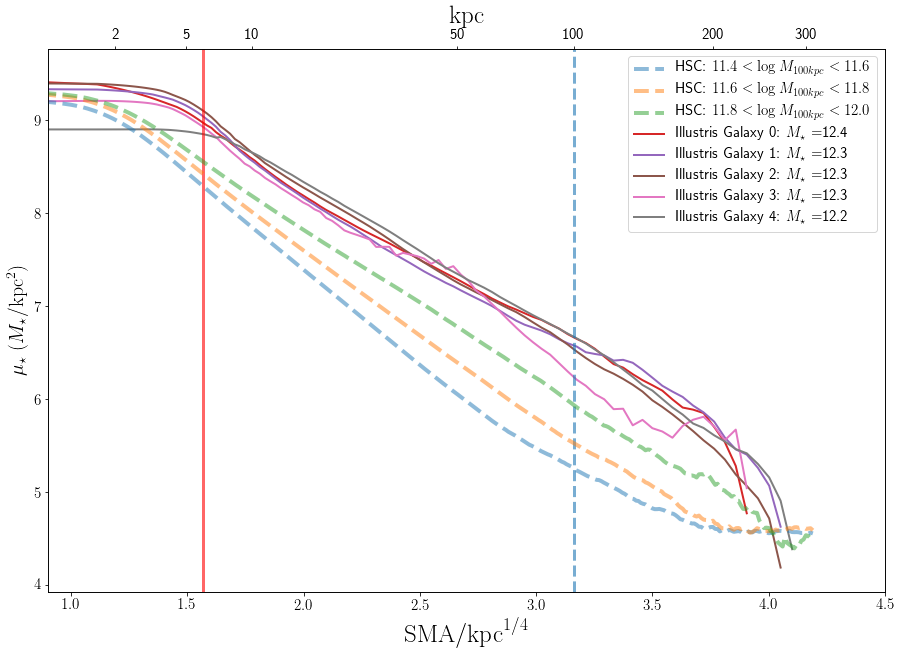

In [21]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twiny()

## Median profiles from HSC
ax1.plot(RSMA_COMMON, rm0_aml[2], linestyle='--', linewidth=4.0, 
         alpha=0.5, zorder=8, label='HSC: $11.4 < \log{M_{100kpc}} < 11.6$')
ax1.plot(RSMA_COMMON, rm1_aml[2], linestyle='--', linewidth=4.0, 
         alpha=0.5, zorder=8, label='HSC: $11.6 < \log{M_{100kpc}} < 11.8$')
ax1.plot(RSMA_COMMON, rm2_aml[2], linestyle='--', linewidth=4.0, 
         alpha=0.5, zorder=8, label='HSC: $11.8 < \log{M_{100kpc}} < 12.0$')

for i in range(5):

    iso_cen = isos[i][0]
    m_star= isos[i][1]
    
    ax1.plot((iso_cen['sma'] * pixel_scale ) ** 0.25, 
         (iso_cen['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0), linewidth=2.0, 
             label='Illustris Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


    
ax1.set_xlim(0.9, 4.5)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax2.set_xlim(x1, x2)
ax2.figure.canvas.draw()
ax2.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax2.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
ax2.set_xlabel(r'$\mathrm{kpc}$', fontsize=25)
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.legend(fontsize=15)

plt.savefig('/Users/fardila/Documents/Github/HSC_vs_hydro/plots/plot.png')
plt.show()


# compare masses